In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
from app.rider import *


In [2]:
WTankCalculator

app.rider.WTankCalculator

Estimated WTank: 25210.00 J


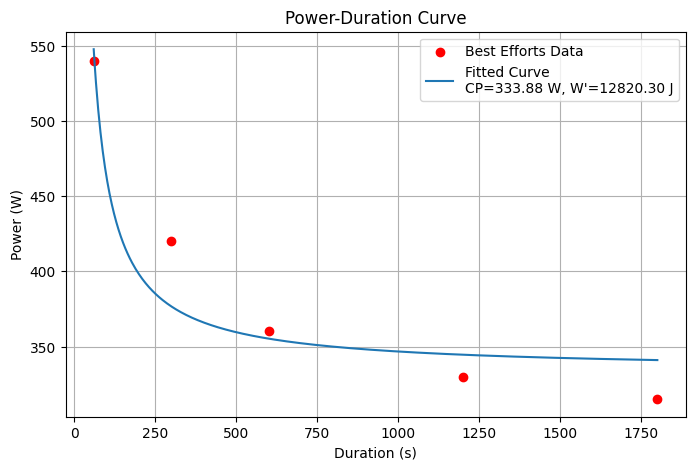

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

class WTankCalculator:
    def __init__(self, rider_type=None, critical_power=None, best_efforts=None):
        """
        Initialize the WTankCalculator class.

        :param rider_type: str, one of ['time_trialist', 'sprinter', 'all_rounder']
        :param critical_power: float, critical power in watts.
        :param best_efforts: dict, best power outputs for durations in seconds.
                             e.g., {60: 400, 300: 350, 600: 330, 1200: 310, 1800: 290}
        """
        self.rider_type = rider_type
        self.critical_power = critical_power
        self.best_efforts = best_efforts if best_efforts else {}

    def _populate_best_efforts(self):
        """
        Populate estimated best efforts if not provided, based on rider type and critical power.
        """
        if not self.critical_power:
            raise ValueError("Critical power must be provided to estimate best efforts.")

        # Base multipliers for power at different durations (relative to critical power)
        if self.rider_type == "time_trialist":
            multipliers = {60: 1.4, 300: 1.2, 600: 1.1, 1200: 1.05, 1800: 1.02}
        elif self.rider_type == "sprinter":
            multipliers = {60: 1.8, 300: 1.4, 600: 1.2, 1200: 1.1, 1800: 1.05}
        elif self.rider_type == "all_rounder":
            multipliers = {60: 1.6, 300: 1.3, 600: 1.15, 1200: 1.08, 1800: 1.03}
        else:
            raise ValueError("Invalid rider type. Choose from 'time_trialist', 'sprinter', or 'all_rounder'.")

        # Populate best efforts based on multipliers
        for duration, multiplier in multipliers.items():
            self.best_efforts[duration] = self.critical_power * multiplier

    def _estimate_w_tank_from_profile(self):
        """Estimate W' based on rider type and critical power."""
        if self.rider_type == "time_trialist":
            return 10_000 + 0.5 * self.critical_power
        elif self.rider_type == "sprinter":
            return 25_000 + 0.7 * self.critical_power
        elif self.rider_type == "all_rounder":
            return 15_000 + 0.6 * self.critical_power
        else:
            raise ValueError("Invalid rider type. Choose from 'time_trialist', 'sprinter', or 'all_rounder'.")

    def _power_duration_model(self, t, CP, W_prime):
        """Power-duration model: P(t) = CP + W'/t."""
        return CP + W_prime / t

    def _estimate_w_tank_from_curve(self):
        """Estimate W' based on the power-duration curve."""
        if not self.best_efforts:
            self._populate_best_efforts()  # Populate best efforts if not provided

        durations = np.array(list(self.best_efforts.keys()))
        powers = np.array(list(self.best_efforts.values()))

        # Curve fitting to estimate CP and W'
        popt, _ = curve_fit(self._power_duration_model, durations, powers, bounds=(0, np.inf))
        estimated_cp, w_prime = popt

        # Store critical power if not provided
        if self.critical_power is None:
            self.critical_power = estimated_cp

        return w_prime

    def calculate_w_tank(self):
        """Calculate the WTank based on available data."""
        if self.best_efforts:
            self.w_tank = self._estimate_w_tank_from_curve()
        elif self.rider_type and self.critical_power:
            self.w_tank = self._estimate_w_tank_from_profile()
        else:
            raise ValueError("Provide either best efforts data or rider profile and critical power.")

        return self.w_tank

    def plot_power_duration_curve(self):
        """Plot the power-duration curve if best efforts data is available."""
        if not self.best_efforts:
            self._populate_best_efforts()  # Populate best efforts if not provided

        durations = np.array(list(self.best_efforts.keys()))
        powers = np.array(list(self.best_efforts.values()))

        # Fit the curve
        popt, _ = curve_fit(self._power_duration_model, durations, powers, bounds=(0, np.inf))
        estimated_cp, w_prime = popt

        # Generate a smooth curve
        t_fit = np.linspace(min(durations), max(durations), 500)
        p_fit = self._power_duration_model(t_fit, *popt)

        # Plot
        plt.figure(figsize=(8, 5))
        plt.scatter(durations, powers, color='red', label='Best Efforts Data')
        plt.plot(t_fit, p_fit, label=f'Fitted Curve\nCP={estimated_cp:.2f} W, W\'={w_prime:.2f} J')
        plt.xlabel('Duration (s)')
        plt.ylabel('Power (W)')
        plt.title('Power-Duration Curve')
        plt.legend()
        plt.grid()
        plt.show()

# Example Usage
# Rider profile (time trialist) with CP=300 W and no best_efforts provided
wt_calculator = WTankCalculator(rider_type='sprinter', critical_power=300)
w_tank = wt_calculator.calculate_w_tank()
print(f"Estimated WTank: {w_tank:.2f} J")

# Plot the estimated power-duration curve
wt_calculator.plot_power_duration_curve()


Critical Power used: 355.93017799401014 W
Estimated WTank (Curve): 11892.014196182605 J


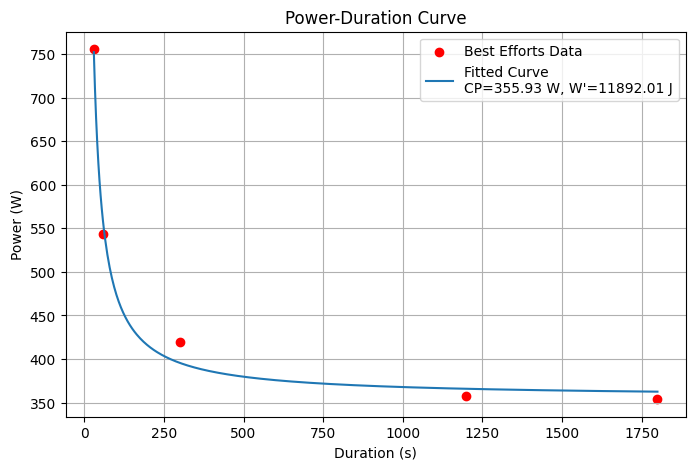

In [19]:
# Best efforts data
#best_efforts_data = {60: 500, 300: 400, 600: 370, 1200: 350, 1800: 305}

wt_calculator_curve = WTankCalculator(best_efforts=critical_power)
w_tank_curve = wt_calculator_curve.calculate_w_tank()
print(f"Critical Power used: {wt_calculator_curve.critical_power} W")
print(f"Estimated WTank (Curve): {w_tank_curve} J")

# Plot the power-duration curve
wt_calculator_curve.plot_power_duration_curve()

In [43]:
critical_power=352
df=pd.DataFrame({'Duration (s)': [15, 60, 120, 300, 600, 2400],'Power (W)': [1200, 681, 520, 464, 412, 366]})
df['W_prime']=(df['Power (W)']-critical_power)*df['Duration (s)']/1000
W_p_avg = df['W_prime'].mean()
print('W tank available: ', W_p_avg, 'kJ')
df['TheoreticalMax']=((critical_power*df['Duration (s)'])+W_p_avg*1000)/df['Duration (s)']
print(2287*(critical_power*.01)**(-.688))
df

W tank available:  25.97 kJ
962.1544927742724


,Duration (s),Power (W),W_prime,TheoreticalMax
0,15,1200,12.72,2083.333333
1,60,681,19.74,784.833333
2,120,520,20.16,568.416667
3,300,464,33.60,438.566667
4,600,412,36.00,395.283333
5,2400,366,33.60,362.820833


In [8]:
import numpy as np

def calculate_w_prime_recovery(
        W_prime_max, 
        W_prime_current, 
        CP, P_recovery, 
        recovery_time, 
        tau_base=2287.2, 
        tau_exponent=-0.688):
    """
    Calculate the W' (anaerobic work capacity) recovery during a recovery period below CP.
    ref: https://journals.humankinetics.com/view/journals/ijspp/13/6/article-p724.xml

    :param W_prime_max: Maximum W' (anaerobic capacity) in joules.
    :param W_prime_current: Current W' value in joules.
    :param CP: Critical power in watts.
    :param P_recovery: Power during recovery in watts.
    :param recovery_time: Duration of recovery in seconds.
    :param tau_base: Base coefficient for tau calculation (default from Skiba model).
    :param tau_exponent: Exponent for tau calculation (default from Skiba model).
    :return: Updated W' after the recovery period.
    """
    # Calculate Deficit Below Critical Power (DCP)
    DCP = CP - P_recovery
    if DCP <= 0:
        # No recovery if power is at or above CP
        return W_prime_current

    # Calculate the time constant of recovery (tau)
    tau_W_prime = tau_base * (DCP ** tau_exponent)

    # Calculate the recovered W' using the exponential recovery formula
    W_prime_recovered = W_prime_max - (W_prime_max - W_prime_current) * np.exp(-recovery_time / tau_W_prime)

    # Ensure W' does not exceed the maximum capacity
    return min(W_prime_recovered, W_prime_max)

# Example Usage
W_prime_max = 25000  # Max W' in joules
W_prime_current = 10000  # Current W' in joules
CP = 351  # Critical power in watts
P_recovery = 200  # Recovery power in watts
recovery_time = 20  # Recovery duration in seconds

W_prime_after_recovery = calculate_w_prime_recovery(W_prime_max, W_prime_current, CP, P_recovery, recovery_time)
print(f"W' after recovery: {W_prime_after_recovery/1000:.2f} kJ")

#At first blush this looks like it's really really overestimating this.  I'm going to try to run some numbers to see if I can get it to work.



W' after recovery: 13.62 kJ


In [7]:
import pandas as pd
from app.strava_calls import *
import numpy as np

def calculate_critical_power(activities, durations):
    """
    Calculate the best critical power for specified durations.

    Args:
        activities: List of activities with IDs.
        durations: List of durations in seconds.

    Returns:
        A dictionary of best critical power for each duration.
    """
    best_power = {duration: 0 for duration in durations}

    for activity in activities:
        activity_id = activity["id"]

        try:
            # Attempt to get the power stream
            power_stream = get_power_stream(activity_id)
        except Exception as e:
            print(f"Error processing activity {activity_id}: {e}")
            continue

        for duration in durations:
            if len(power_stream) >= duration:
                avg_power = max(
                    np.mean(power_stream[i:i + duration])
                    for i in range(len(power_stream) - duration + 1)
                )
                best_power[duration] = max(best_power[duration], avg_power)

    return best_power



# Main workflow
try:
    print('starting')
    activities = get_activities()  # Retrieve activities using the token from auth.py
    print('activities', activities)
    durations = [5, 30, 60, 300, 1200, 60*30]  # Durations in seconds (5s, 30s, 1min, 5min, 20min)
    critical_power = calculate_critical_power(activities, durations)

    print("Critical Power Profile:")
    for duration, power in critical_power.items():
        print(f"{duration if duration<60 else duration/60}",("s" if duration<60 else "m"), f"{power:.2f} watts")
except Exception as e:
    print(f"Error: {e}")
    print("Traceback:")
    print(traceback.format_exc())

    #Activieis gets last 30 days
    

starting
activities [{'resource_state': 2, 'athlete': {'id': 186207, 'resource_state': 1}, 'name': 'Cycling', 'distance': 0.0, 'moving_time': 1845, 'elapsed_time': 1845, 'total_elevation_gain': 0, 'type': 'Ride', 'sport_type': 'Ride', 'workout_type': None, 'id': 13513376874, 'start_date': '2025-02-01T20:07:01Z', 'start_date_local': '2025-02-01T12:07:01Z', 'timezone': '(GMT-08:00) America/Ensenada', 'utc_offset': -28800.0, 'location_city': None, 'location_state': None, 'location_country': 'United States', 'achievement_count': 0, 'kudos_count': 4, 'comment_count': 0, 'athlete_count': 1, 'photo_count': 0, 'map': {'id': 'a13513376874', 'summary_polyline': '', 'resource_state': 2}, 'trainer': True, 'commute': False, 'manual': False, 'private': False, 'visibility': 'everyone', 'flagged': False, 'gear_id': 'b2797788', 'start_latlng': [], 'end_latlng': [], 'average_speed': 0.0, 'max_speed': 0.0, 'average_cadence': 81.7, 'average_temp': 4, 'average_watts': 245.6, 'max_watts': 679, 'weighted_ave

In [1]:
import traceback
from app.strava_calls import get_activities, get_power_stream
import numpy as np
import datetime

def calculate_critical_power(activities, durations):
    best_power = {duration: 0 for duration in durations}

    for activity in activities:
        activity_id = activity["id"]

        try:
            power_stream = get_power_stream(activity_id)
        except Exception as e:
            print(f"Error processing activity {activity_id}: {e}")
            continue

        for duration in durations:
            if len(power_stream) >= duration:
                avg_power = max(
                    np.mean(power_stream[i:i + duration])
                    for i in range(len(power_stream) - duration + 1)
                )
                best_power[duration] = max(best_power[duration], avg_power)

    return best_power

def get_critical_power_profile(days=60):
    try:
        print('Starting critical power profile calculation')
        activities = get_activities(days)  # Retrieve activities from the past `days` days
        print('Activities:', activities)
        durations = [15, 30, 60, 120, 300, 1200, 60*30]  # Durations in seconds (5s, 30s, 1min, 5min, 20min)
        critical_power = calculate_critical_power(activities, durations)

        print("Critical Power Profile:")
        for duration, power in critical_power.items():
            print(f"{duration if duration < 60 else duration / 60}{'s' if duration < 60 else 'm'}: {power:.2f} watts")
        
        return critical_power
    except Exception as e:
        print(f"Error: {e}")
        print("Traceback:")
        print(traceback.format_exc())
        return None

# Example usage
if __name__ == "__main__":
    critical_power_profile = get_critical_power_profile(days=60)
    
    if critical_power_profile:
        print("Critical Power Profile successfully calculated.")

Starting critical power profile calculation
Activities: [{'resource_state': 2, 'athlete': {'id': 186207, 'resource_state': 1}, 'name': 'Cycling', 'distance': 0.0, 'moving_time': 1845, 'elapsed_time': 1845, 'total_elevation_gain': 0, 'type': 'Ride', 'sport_type': 'Ride', 'workout_type': None, 'id': 13513376874, 'start_date': '2025-02-01T20:07:01Z', 'start_date_local': '2025-02-01T12:07:01Z', 'timezone': '(GMT-08:00) America/Ensenada', 'utc_offset': -28800.0, 'location_city': None, 'location_state': None, 'location_country': 'United States', 'achievement_count': 0, 'kudos_count': 10, 'comment_count': 0, 'athlete_count': 1, 'photo_count': 0, 'map': {'id': 'a13513376874', 'summary_polyline': '', 'resource_state': 2}, 'trainer': True, 'commute': False, 'manual': False, 'private': False, 'visibility': 'everyone', 'flagged': False, 'gear_id': 'b2797788', 'start_latlng': [], 'end_latlng': [], 'average_speed': 0.0, 'max_speed': 0.0, 'average_cadence': 81.7, 'average_temp': 4, 'average_watts': 2